### Digit Classifier

In [1]:
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

Loading our dataset:

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

Sampling one of the images from the dataset:

In [4]:
im3 = Image.open(threes[1])
im3

Using a Dataframe to visualize the image values:

In [5]:
im3_t = tensor(im3)
im3_df = pd.DataFrame(im3_t[4:18,5:22])
im3_df.style.set_properties(**{'font-size': '10pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


<Axes: >

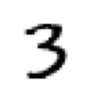

In [6]:
show_image(im3_t)

Let's stack our images into a tensor. There should be 6131 threes & 6265 sevens of 28x28 pixels:

In [7]:
threes_tensor = torch.stack([tensor(Image.open(img)) for img in threes]).float()/255
sevens_tensor = torch.stack([tensor(Image.open(img)) for img in sevens]).float()/255

threes_tensor.shape, sevens_tensor.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

Let's average all the images to find our 'ideal' 3:

<Axes: >

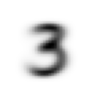

In [8]:
mean3 = threes_tensor.mean(0)
show_image(mean3)

And now our ideal 7:

<Axes: >

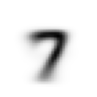

In [9]:
mean7 = sevens_tensor.mean(0)
show_image(mean7)

Now let's define a distance for a given image to our 'ideal' image. There are 2 common ways in this context:
1. L1 norm or Mean Absolute Difference
2. L2 norm or Root Mean Squared Error (RMSE)

The latter will penalize bigger mistakes more heavily than the former.

In [10]:
def mean_abs_diff(x, y):
    return (x - y).abs().mean()

def root_mean_squared_error(x, y):
    return ((x - y) ** 2).mean().sqrt()

PyTorch provides both of these as loss functions via `torch.nn.functional` usually imported as `F` (also available as such in fastai)

In [11]:
print(mean_abs_diff(im3_t, mean3), F.l1_loss(im3_t, mean3))
print(root_mean_squared_error(im3_t, mean3), F.mse_loss(im3_t, mean3).sqrt())

tensor(36.2508) tensor(36.2508)
tensor(89.4386) tensor(89.4386)


Our first attempt at classifying an input image as a 3 or a 7 will be by calculting the distace between our image and the ideal image. This should be better than nothing and it will be our baseline.

To determine if our baseline model is anygood, let's define a metric and calcuate it using the MNIST validation dataset:

In [12]:
valid_3_tens = torch.stack([tensor(Image.open(img)) for img in (path/'valid'/'3').ls()]).float() / 255
valid_7_tens = torch.stack([tensor(Image.open(img)) for img in (path/'valid'/'7').ls()]).float() / 255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Let's define our distance function similar as we did before, but instead of calculating the distance between 2 images let's caculate the difference between an image and the validation set (multiple images). This should result in a tensor which contains the distance for each image in the validation set.

In [13]:
def mnist_distance(a, b):
    
    # NB Broadcasting 
    # [1010, 28, 28] - [28, 28] --> [1010, 28, 28]
    # [1010, 28, 28].abs() -> [1010, 28, 28]
    # [1010, 28, 28].mean((-1, -2)) -> [1010]  ie. mean for each image
    return (a - b).abs().mean((-1, -2))


mnist_distance(valid_3_tens, mean3), mnist_distance(valid_3_tens, mean3).shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

And we can define a function that determines if an image is a 3:

In [14]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [15]:
is_3(im3_t), is_3(im3_t).float()

(tensor(True), tensor(1.))

And now we can calculate the accuracy of our baseline model:

In [16]:
accuracy_3s =      is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

#### Using Stochastic Gradient Descent (SGD) instead

Let's define our training set inputs and labels:

In [17]:
# Concat 3s & 7s and make a single row out of each 28*28 image
train_x = torch.cat([threes_tensor, sevens_tensor]).view(-1, 28*28)

# Let's use 1 for labelling 3s and 0 for labelling zeros
train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

train_x.shape, train_y.shape


(torch.Size([12396, 784]), torch.Size([12396, 1]))

And now our validation set inputs and labels:

In [18]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)

valid_x.shape, valid_y.shape

(torch.Size([2038, 784]), torch.Size([2038, 1]))

Initialize our weights with random normal distribution and our bias:

In [19]:
weights = torch.randn(28*28,1).requires_grad_()
bias = torch.randn(1)

train_x.shape, weights.shape, bias.shape

(torch.Size([12396, 784]), torch.Size([784, 1]), torch.Size([1]))

And now we can run our predictions:

In [20]:
preds = train_x@weights + bias
preds

tensor([[17.5601],
        [17.4198],
        [14.5786],
        ...,
        [ 9.6380],
        [13.3237],
        [16.5263]], grad_fn=<AddBackward0>)

Remember we use `1` to represent `3s` and `0` to represent `7s`. So we can now check which predictions are above zero and compare it with the training labels to get the correct predictions.

In [21]:
corrects = (preds > 0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

Calculating our accuracy:

In [22]:
print(f'Accuracy: {corrects.float().mean().item():.2%}') 

Accuracy: 49.66%


Now let's change one of the weights and see how it affects our model accuracy.

In [23]:
with torch.no_grad(): weights[0] *= 1.0001
preds = train_x@weights + bias
corrects = (preds > 0.0).float() == train_y
print(f'Accuracy: {corrects.float().mean().item():.2%}')

Accuracy: 49.66%


Accuracy hasn't changed. Since we're using `True` and `False` here for our predicions, it's unlikely that a small change in our weights will cause a change in the predictions. Also let's ensure our predictions fall between 0 and 1 by using a `sigmoid` function.

In [24]:
for k in range(1000):
    preds = (train_x@weights + bias).sigmoid()
    loss = (preds - train_y).abs().mean()

    if k % 100 == 0:
        print(loss.item())

    weights.grad = None
    loss.backward()
    weights.data -= weights.grad * 0.1


0.5013288855552673
0.47630050778388977
0.2664426267147064
0.1438225358724594
0.1080520823597908
0.09123412519693375
0.0813373550772667
0.0745953693985939
0.06958261877298355
0.06563961505889893


In [25]:
preds = (valid_x@weights + bias).sigmoid()
corrects = (preds > 0.5).float() == valid_y
accuracy = corrects.float().mean().item()

print(f'Accuracy: {accuracy:.2%}')

Accuracy: 94.16%


Got a bit ahead of myself here with the training. Let's use a `Dataset` (independent & dependent variables tupes, ie. input & labels) and a `Dataset` to create mini-batches for training and validation.

In [26]:
dset = list(zip(train_x, train_y))
dset_valid = list(zip(valid_x, valid_y))

dl = DataLoader(dset, batch_size=256, shuffle=True)
dl_valid = DataLoader(dset_valid, batch_size=256, shuffle=True)

xb,yb = first(dl)
xb.shape,yb.shape


(torch.Size([256, 784]), torch.Size([256, 1]))

We can use PyTorch's `nn.Linear` to init our weights and bias

In [27]:
linear_model = nn.Linear(28*28, 1)

w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

And now let's put our previous definitions into a few function:

In [28]:
def calc_loss(preds, labels):
    return (preds.sigmoid() - labels).abs().mean()

def calc_grad(inputs, labels, model):
    preds =  model(inputs)
    loss = calc_loss(preds, labels)
    loss.backward()

def calc_accuracy(preds, labels):
    corrects = (preds.sigmoid() > 0.5).float() == labels
    return corrects.float().mean()

def validate(model):
    accs = [calc_accuracy(model(xb), yb) for xb,yb in dl_valid]
    return round(torch.stack(accs).mean().item(), 4)

Let's create an _Optimizer_ object which handles SDG for us

In [29]:
class BasicOptimizer:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params:
            p.grad = None

And now put it all together:

In [30]:
opt = BasicOptimizer(linear_model.parameters(), 0.001)

def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

for k in range (5):
    train_epoch(linear_model)
    print(validate(linear_model))

0.8632
0.918
0.9343
0.9416
0.9495


We can replace our BasicOptimizer by fastai's SDG which does the same by default:

In [31]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), 0.001)

def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

def train_model(model, epochs):
    for k in range (epochs):
        train_epoch(model)
        print(validate(model))

train_model(linear_model, 10)

0.7193
0.8258
0.8798
0.9121
0.9248
0.9367
0.9431
0.9466
0.9506
0.9534


FastAI also provides `Learner.fit` that we can use instead of train_model. 

In [32]:
dls = DataLoaders(dl, dl_valid)
learner = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=calc_loss, metrics=calc_accuracy)

learner.fit(10, lr=0.01)

epoch,train_loss,valid_loss,calc_accuracy,time
0,0.400941,0.326003,0.962709,00:00
1,0.304855,0.230018,0.962218,00:00
2,0.237246,0.181123,0.963690,00:00
3,0.191852,0.152850,0.963690,00:00
4,0.162056,0.134534,0.963690,00:00
5,0.140806,0.121673,0.964671,00:00
6,0.126230,0.112126,0.964671,00:00
7,0.115898,0.104701,0.964671,00:00
8,0.107522,0.098750,0.964671,00:00
9,0.100881,0.093855,0.964671,00:00


#### Adding a Nonlinearity

A single linear layer is pretty contrained. We can add multiple linear layers but that will still be linear. The trick is to add a non linear function, like `max` in between then. 

In [33]:
w1 = torch.randn(28*28,30).requires_grad_()
b1 = torch.randn(30)

w2 = torch.randn(30,1).requires_grad_()
b2 = torch.randn(1)

def simple_net(xb): 
    res = xb@w1 + b1                # linear layer
    res = res.max(tensor(0.0))      # non linearity (or activation fuction)
    res = res@w2 + b2               # linear layer
    return res

simple_net(train_x[:10])

tensor([[-76.5494],
        [-74.6487],
        [-27.5551],
        [-35.1143],
        [-53.3498],
        [-33.3451],
        [ -9.6097],
        [-24.3070],
        [ -9.3640],
        [ -4.9018]], grad_fn=<AddBackward0>)

Using PyTorch instead:

In [34]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=calc_loss, metrics=calc_accuracy)

learn.fit(40, 0.01)

epoch,train_loss,valid_loss,calc_accuracy,time
0,0.477388,0.460715,0.953386,00:00
1,0.446057,0.409082,0.970069,00:00
2,0.397831,0.339814,0.971050,00:00
3,0.336174,0.266948,0.972031,00:00
4,0.271519,0.205384,0.970069,00:00
5,0.215443,0.161276,0.969578,00:00
6,0.171730,0.131661,0.969578,00:00
7,0.141182,0.111714,0.968597,00:00
8,0.118688,0.097805,0.968106,00:00
9,0.102563,0.087700,0.968597,00:00
